## Installing dependencies:

In [1]:

!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install pyglet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 49.0 MB/s eta 0:00:00
  Attempting uninstall: pygame
    Found existing installation: pygame 2.3.0
    Uninstalling pygame-2.3.0:
      Successfully uninstalled pygame-2.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.0 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.6.0
    Uninstalling setuptools-67.6.0:
      Successfully uninstalled setuptools-67.6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.9.0 requires jedi>=0.10, which is not installed.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/p

In [2]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing dependencies and define helper functions

In [3]:

import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from typing import Any, List, Sequence, Tuple
from tensorflow.keras import layers
import tqdm
import statistics
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
import collections

from tensorflow.keras.losses import Huber as huber

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")

## Tutorial: Loading CartPole environment

In [4]:
# CREATE ENV
env = gym.make("CartPole-v1")

We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

In [5]:

print(env.action_space)

Discrete(2)


The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [6]:

print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. This initialization can be achieved by the code below, which returns the observation of the initial state.

In [7]:

observation = env.reset()
print("Initial observations:", observation)

Initial observations: [-0.01435321 -0.01604889  0.03553538  0.02224773]


For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project). For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

In [8]:

observation, reward, done, info = env.step(0)
print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)

New observations after choosing action 0: [-0.01467418 -0.21166195  0.03598034  0.3259273 ]
Reward for this step: 1.0
Is this round done? False


Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [9]:

observation = env.reset()
cumulative_reward = 0
done = False
while not done:
    observation, reward, done, info = env.step(0)
    print(observation, done, info)
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)
# [cart position, velocity, pole angle, angular velocity]

[-0.04537834 -0.19077793 -0.04205066  0.27981415] False {}
[-0.0491939  -0.38527557 -0.03645438  0.5589435 ] False {}
[-0.05689941 -0.57986736 -0.02527551  0.8399221 ] False {}
[-0.06849676 -0.7746353  -0.00847707  1.1245503 ] False {}
[-0.08398946 -0.9696451   0.01401394  1.4145623 ] False {}
[-0.10338236 -1.1649379   0.04230519  1.7115927 ] False {}
[-0.12668112 -1.3605193   0.07653704  2.0171363 ] False {}
[-0.1538915  -1.5563474   0.11687977  2.3324986 ] False {}
[-0.18501845 -1.7523164   0.16352974  2.6587307 ] False {}
[-0.22006477 -1.9482392   0.21670435  2.9965582 ] True {'TimeLimit.truncated': False}
Cumulative reward for this round: 10.0


## Introduction

RL algorithms can be classified into critic-only, actor-only and actor-critic methods. The actor-critic method is used to combine the advantages of actor-only and critic-only methods. The parameterized actor has the benefit of being able to generate continuous actions without requiring optimization procedures on a value function, whereas the critic's advantage is providing the actor with low-variance information about its performance.

Source: https://aadeshnpn.com/wp-content/uploads/2018/09/actor-critic-reinforcement.pdf

The main method that we will be using is the Actor-Critic method. Actor-Critic methods utilize temporal difference (TD) learning techniques to model the policy function and value function separately. A value function determines the expected return for an agent following a certain policy indefinitely from a given state. On the other hand, a policy function provides a probability distribution across the possible actions depending on the present state.

The Actor-Critic approach involves two components: the actor and the critic. The involved policy is the actor that will propose a set of potential actions based on the current situtation. For the other component, the critic, it is the estimated value function that will assess the actor's performance based on the current policy.

The critic network establishes a correlation between the state vectors and the negative reinforcement value. Using TD learning, the network will gain knowledge of the expected value of a discounted sum of future negative reinforcement signals.

Source: https://arxiv.org/pdf/1810.01940.pdf

Source: https://ieeexplore.ieee.org/abstract/document/24809

In the following sections, we propose an Actor-Critic method to help with the CartPole problem. It first starts off with the development of the Reinforcement Learning agent. One neural network with two outputs will be used to represent both the actor and critic. We will then demonstrate the effectiveness of the reinforcement learning agent, followed by rendering one episode that is played by the agent to visualize the mechanics behind the implementation.

## Task 1: Development of an RL agent

The following cell is where we define the neural network for the Actor-Critic method. The actor portion of the model will generate the probabilities for the possible actions, while the critic part of it will generate the critic value. We have created a class ActorCriticMain to define the model for use. By using a class, it provides the modularity that can help with troubleshooting and reuse of the model multiple times in the project. In is also a useful way of combining data and functionality. 



In [10]:

# ------------------------------------------------------------------------------
# ===Actor-Critic Network===
# Here, we used a single network for both the actor and the critic. We have two 
# common lower layers and two outputs. For the output, one is for the actor, and 
# the other is for the critic. The reason for using 1 neural network is that we 
# do not have to train two different neural networks to understand the 
# environment. We have created a class for the actor critic neural network 
# as shown below. Our actor-critic model class will be derived from the base 
# model class from the Tensorflow. The model will take in the state as the 
# input and will output both action probabilities and critic value , which 
# models the state-dependent value function. The goal is to train a model that  
# chooses actions based on a policy that maximizes expected return.


# ===About the Actor===
# The actor in this case will model the policy, which is the probability 
# distribution. The actor layer will have as many outputs as there are actions, 
# and the softmax activation is used as we are modeling probabilities, which 
# need to sum to one. When selecting the actions, we are choosing from a 
# discrete action space, and hence a categorical distribution will be used 
# in the implementation. 
# ------------------------------------------------------------------------------

# Define Actor Critic Class
class ActorCriticMain(tf.keras.Model):
  # Define constructor and take the number of possible moves as input. 
  def __init__(self, possible_moves, nodes_count_1, nodes_count_2):
    # Call super constructor
    super().__init__()

    # --------------------------------------------------------------------------
    # ===Defining the Layers===
    # Here are fully connected Dense layers. We have two common layers and 2 
    # independent outputs. For keras, the number of input dimensions are 
    # infererred, so we did not specify the input dimensions in the constructor. 
    # The activation that we have used is relu
    # --------------------------------------------------------------------------

    # We considered adding Dropout to avoid overfitting if the results are not 
    # good but results seems satisfactory so we did not.

    # We also tried a few number of hidden layers and found that by trial and 
    # error, this is by far the optimal one.
    self.fully_connected_1 = layers.Dense(nodes_count_1, activation="relu")
    self.fully_connected_2 = layers.Dense(nodes_count_2, activation="relu")

    # --------------------------------------------------------------------------
    # ===Layer Outputs===
    # We will have 2 separate outputs. The first output is the critic function. 
    # It is single value with no activation. The actor is our second output, 
    # which is also our policy pi. It will output the possible moves. Upon 
    # getting this output, we will run it through a softmax activation. The 
    # policy is just a probability distribution, so using the categorical 
    # function in the later part, it will assign each probability to each 
    # action. 
    # --------------------------------------------------------------------------

    # We have 2 output layers.

    # Actor is policy pi which output the feasible action, 0 or 1 based on 
    # probabilities using softmax function.
    self.actor = layers.Dense(possible_moves) 

    # Critics evaluate the action produced by the actor by computing the value 
    # function. 
    # Link: https://medium.com/intro-to-artificial-intelligence/the-actor-critic-reinforcement-learning-algorithm-c8095a655c14
    self.critic = layers.Dense(1) 


  # The call function is for the forward pass during the model training
  def call(self, inputs):
    # We will pass the information through the two common connected layers
    fully_connected_1_output = self.fully_connected_1(inputs)
    fully_connected_2_output = self.fully_connected_2(fully_connected_1_output)
    actor_tensor = self.actor(fully_connected_2_output)
    critic_tensor = self.critic(fully_connected_2_output)

    # And return both the critic value and the actor policy pi
    return actor_tensor, critic_tensor


### TrainingModel Class


In this class, the following steps were carried out to train the agent:  
1. Firstly, we get the training data for every episode using the agent placed in the environment.  
2. Secondly, determine the expected return for each time step.  
3. Next, generate the loss for the combined Actor-Critic method and update the network parameters with the newly computed gradient thereafter.  
4. Lastly, repeat the previous steps till the success criterion or maxiumum number of episodes are fulfilled

In [11]:
class TrainingModel:
  def __init__(self, value_of_gamma, maximum_moves_per_episode, possible_moves, 
               nodes_count_1, nodes_count_2, optimizer, tf_huber):
    self.value_of_gamma = value_of_gamma
    self.maximum_moves_per_episode = maximum_moves_per_episode
    self.model = ActorCriticMain(possible_moves, nodes_count_1, nodes_count_2)
    self.optimizer = optimizer
    self.tf_huber = tf_huber
  
  # This function will return the observation, reward and done flag based on a given action
  def gym_step(self, action):
    '''
    At each step, "gym_step" method produces probabilities for actions and a 
    value for the critic, both of which are determined by the current policy 
    that is parameterized by the weights of the model.
    '''
    obs, reward, done, info = env.step(action)
    output_tuple = (obs.astype(np.float32), np.array(reward, np.int32), np.array(done, np.int32))
    return output_tuple

  # ----------------------------------------------------------------------------
  # ===Starting and running episode===
  # We need training data to train the actor-critic model, just like with 
  # supervised learning. However, the model must be run in the environment in 
  # order to acquire such data. Each episode generates training data, and the 
  # model does a forward pass on the state of the environment at each time step 
  # using its weights to generate action probabilities and the critic value 
  # based on the current policy.

  # For the function below, we get the learning data for each episode 
  # for the model to run on. The "start_eps" method will sample the next action 
  # from the action probabilities generated by the model, which would then 
  # be applied to the environment to produce the next state and reward.
  # ----------------------------------------------------------------------------

  # This function will run one episode to get training data
  def start_eps(self, initial_obs):

    SIZE = 0
    obs = initial_obs
    initial_obs_shape = initial_obs.shape
    num_sequence_limit = tf.range(self.maximum_moves_per_episode)

    # Here we use dynamic_size = True to allow TensorArray to be written past its initial size.
    rewards = tf.TensorArray(dtype=tf.int32, size = SIZE, dynamic_size=True)
    vals = tf.TensorArray(dtype=tf.float32, size = SIZE, dynamic_size=True)
    move_probs = tf.TensorArray(dtype=tf.float32, size = SIZE, dynamic_size=True)

    # Here we run the model for maximum_moves times
    for curr in num_sequence_limit:
      # Here, the observation is converted into a batched tensor (batch size = 1). 
      # We have to add an extra dimension (batched dim) as the deep neural network 
      # expects a batch of inputs. 
      obs = tf.expand_dims(obs, 0)
    
      # Call our action-critic model and generate the probabilities of actions 
      # and critic value given the obs
      prob_dist, critic_v = self.model(obs)
    
      # Here, we draw next move (sample) from the categorical move probability 
      # distribution. We use the probabilities defined by our neural network to 
      # feed into the tensorflow probability categorical distribution and use 
      # that to select a move by sampling the distribution. It will be needed 
      # for the calculation for the log probability.
      move = tf.random.categorical(prob_dist, 1)[0, 0] # we put 1 to get 1 sample.
      move_probs_t = tf.nn.softmax(prob_dist) # generate the softmax activations

      # Record critic values by plain writing to TensorFlow Array for vals.
      # We have to squeeze the value as the loss works best if it is on a one dimensional quantity.
      vals = vals.write(curr, tf.squeeze(critic_v))

      # Record log probability of the chosen move by plain writing to TensorFlow Array for move_probs
      # Get the 0th element of that because we added in the batch dimension earlier for compatibility with our neural network.
      # This is the move that we saved at the top when we calculate the move for the agent. This is the most recent action.
      move_probs = move_probs.write(curr, move_probs_t[0, move])
    
      # Get next observation and reward based on the move taken
      # We convert gym_step, a python function to a tensorflow function to achieve this.
      obs, reward, done = tf.numpy_function(self.gym_step, [move], [tf.float32, tf.int32, tf.int32])

      # Record reward by plain writing to TensorFlow Array for rewards
      rewards = rewards.write(curr, reward)

      # Here, we update the shape of obs_shape tensor
      obs.set_shape(initial_obs_shape)

      # We try casting done flag to boolean dtype. If true, it means 
      if tf.cast(done, tf.bool):
        break

    # We return all the values in the move_probs TensorArray as a stacked Tensor.
    move_probs = move_probs.stack()

    # We return all the values in the rewards TensorArray as a stacked Tensor.
    rewards = rewards.stack()

    # We return all the values in the vals TensorArray as a stacked Tensor.
    vals = vals.stack()
    
    return move_probs, vals, rewards


  # ----------------------------------------------------------------------------
  # ===Computing expected returns===
  # During a single episode, the rewards obtained at each time step are 
  # transformed into a series of anticipated returns - whereby the rewards from 
  # the current time step up to the maximum time step are summed up and 
  # multiplying each reward by a progressively decreasing discount factor.
  # ----------------------------------------------------------------------------


  def generate_return(self, value_of_rewards, normalize = True):
    # Calculates the expected returns for every time step

    # Here, we are setting the sizes of output first
    output = tf.TensorArray(dtype = tf.float32, size = tf.shape(value_of_rewards)[0])

    # Begin with the final element of the rewards sequence and add up the rewards to store the resulting sums in the output array.
    decaying_reward = tf.constant(0.0)
    decaying_reward_shape = decaying_reward.shape

    # We convert values_of_rewards to float values
    value_of_rewards = tf.cast(value_of_rewards[::-1], dtype = tf.float32)
    
    # We perform a for loop in tensorflow
    for curr in tf.range(tf.shape(value_of_rewards)[0]):

      # Get the value of decaying_reward by decaying the reward (multiplying with gamma)
      decaying_reward = decaying_reward * self.value_of_gamma

      # Adding curr reward to our decaying_reward
      decaying_reward += value_of_rewards[curr]

      # Update the shape of decaying_reward tensor
      decaying_reward.set_shape(decaying_reward_shape)

      # Write decaying_reward into curr index of 'output' TensorArray
      output = output.write(curr, decaying_reward)

    # Here we return the values in the 'output' TensorArray as a stacked Tensor with 1 backward step.
    output = output.stack()[::-1]

    if normalize:
      output = ((output - tf.math.reduce_mean(output)) / (tf.math.reduce_std(output) + np.finfo(np.float32).eps.item()))

    return output


  # ----------------------------------------------------------------------------
  # ===Computing Actor-Critic Loss===
  # The actor-critic loss uses a loss function that combines the losses of both 
  # the actor and the critic. The advantage, referred to as 'gain' in our code,
  # is contained in the actor loss formulation. The advantage is the degree of 
  # improvement that can happen by taking the action in a specific state, 
  # instead of choosing a random action that is based on the policy pi for that 
  # state. If an action is doing better than expected, we want to prompt the 
  # actor to replicate that action. Conversely, if an action is doing worse than 
  # expected, the actor should be encouraged to take the opposite action. When 
  # an action meets the expected performance level, there is no learning 
  # opportunity for the actor. Hence, the advantage can decide which actions 
  # to encourage by deciding how to scale the action that the agent just took. 
  # Source: https://towardsdatascience.com/advantage-actor-critic-tutorial-mina2c-7a3249962fc8#:~:text=In%20the%20field%20of%20Reinforcement,input%20states%20to%20output%20actions.

  # ===Actor Loss===
  # The Actor loss is determined using policy gradients, with the Critic 
  # functioning as a baseline that is dependent on the current state. 
  # Additionally, this loss is calculated using estimates derived from a single 
  # sample per episode. 

  # ===Critic Loss===
  # For the critic loss, Huber loss is used for its calculation. Huber Loss is 
  # a combination of both Mean Square Error and Mean Absolute Error. Mean Square
  # Error is good for learning the outliers, while Mean Absolute Error is good 
  # for ignoring the outliers. Huber loss is good for situations where higher 
  # weightage should not be given to the outliers. 
  # Source: https://gobiviswa.medium.com/huber-error-loss-functions-3f2ac015cd45
  # ----------------------------------------------------------------------------


  # Calculates the combined loss for Actor-Critic 
  def calculate_loss(self, move_probs,  values, return_vals):

    # Calculate critic loss 
    critic_loss = self.tf_huber(values, return_vals)

    # Calculate actor loss 
    # tf.math.log(move_probs) represents the log of move's probability
    # (return_vals - values) represents gain, which is how much better a move is based on a given state than a random move based on the policy pi
    actor_loss = -tf.math.reduce_sum(tf.math.log(move_probs) * (return_vals - values))

    # Calculate combined loss 
    combined_loss = critic_loss + actor_loss

    return combined_loss
  

  # ----------------------------------------------------------------------------
  # ===Training the Model===
  # This function, train() will be used to train the model. The "train()" 
  # method will be run every episode. For a substantial speedup in training, 
  # @tf.function context is added. To enable automatic differentiation for all 
  # steps before computing the loss function, @tf.GradientTape() context is added. 

  # While the agent is exploring its surroundings, the critic network tries to 
  # minimize the advantage function. Initially during the learning phase, the 
  # critic will likely make large errors, causing the calculate temporal 
  # difference error to be inaccurate. Since the critic lacks understanding of 
  # the environment at the beginning, the actor cannot gain much knowledge from 
  # the critic. However, as the critic begins to predict outcomes more accurately, 
  # the advantage calculation improves in accuracy as well. Through the 
  # repetition of this learning process over many game episodes, the actor and 
  # critic will learn to balance the pole for a longer time.
  # Source: https://towardsdatascience.com/advantage-actor-critic-tutorial-mina2c-7a3249962fc8#:~:text=In%20the%20field%20of%20Reinforcement,input%20states%20to%20output%20actions.
  # ----------------------------------------------------------------------------

  # Execute the model training the step
  @tf.function
  def train(self, initial_obs):
    # Calculate the actual gradient using gradient tape
    with tf.GradientTape() as tape:

      # Consolidate the learning data by executing the model for 1 episode
      move_probs, values, rewards = self.start_eps(initial_obs) 

      # Here, we generate the expected returns
      returns = self.generate_return(rewards)

      # Change the learning data to the corresponding Tensorflow tensor shapes
      move_probs, values, returns = [tf.expand_dims(x, 1) for x in [move_probs, values, returns]] 

      # The loss values will be calculated here
      loss_vals = self.calculate_loss(move_probs, values, returns)

    # The calculated loss values will be used to update the neural network
    gradients = tape.gradient(loss_vals, self.model.trainable_variables)

    # The gradients are applied to the neural network's parameters
    self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

    episode_reward = tf.math.reduce_sum(rewards)

    return episode_reward


# Code references: 
# https://github.com/philtabor/Youtube-Code-Repository/tree/master/ReinforcementLearning
# https://keras.io/examples/rl/actor_critic_cartpole/

#### Run training loop

We run the training step until either the success criterion has been met, or maximum number of episodes is reached.

To summarize the overview of the algorithm, we will first initialise the actor-critic network. And by repeating for a large number of episodes, we will reset the environment, score and terminal flag. And while the state is not terminal, we will select the action according to the policy of the actor network. The action will be taken to receive the reward and the new state. The scores will be saved over time for evidence of learning.


From the results shown below, there is an overall increase in score over time. But we observed that there are oscillations in the scores. This can attributed to the fact that actor-critic methods are not very stable. This is also observed by Nadendra and his team (source: https://arxiv.org/pdf/1810.01940.pdf). Their team had also observed large oscillations when running their actor-critic policy gradient method. They postulated that the periodic variations could be due to the characteristics of actor-critic methods.


But the overall trend should be increasing. Another observation was that the score can go up for a while then fall off to a lower value. This can be attributed to the cause that the actor-critic method might not be the best solution for all the cases. But this can be set as the basis for more advanced algorithms that can be used for future work. 

In [12]:

# Here we initialise our training model, actor-critic.
trainingAgent = TrainingModel(
    value_of_gamma = 0.99, 
    maximum_moves_per_episode = 500, 
    possible_moves = 2, 
    nodes_count_1 = 256, 
    nodes_count_2 = 128,
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
    tf_huber = huber(reduction=tf.keras.losses.Reduction.SUM)
    # Instead of using MSE, we use Tensorflow Huber as it is less sensitive to outlier as mentioned in this link (It handles outliers better than): 
    # https://www.numpyninja.com/post/loss-functions-when-to-use-which-one#:~:text=Huber%20Loss%20is%20often%20used,of%20both%20MSE%20and%20MAE.&text=a)%20Outliers%20are%20handled%20properly.
    # Here we initialise the tensor flow for huber loss for critic loss usage later.
    # We use SUM for loss reduction as we want the scalar sum of weighted loss for calculating critic loss later
    )

maximum_episodes = 15000
minimum_episodes = 100

# According to the link below, CartPole-v1 has a reward_threshold of 475. This means when the average rewards hit 475, it is considered solved. 
# Hence, we set reward threshold as 475.
# https://stackoverflow.com/questions/56904270/difference-between-openai-gym-environments-cartpole-v0-and-cartpole-v1
curr_avg_reward = 0
reward_threshold = 475

# Here, we will keep the reward of the latest 100 episode in a queue, which uses FIFO order, making it suitable for our use case.
episodes_reward = collections.deque(maxlen=minimum_episodes)

bar_range = tqdm.trange(maximum_episodes)

# Here we loop through all the episodes starting from 0 to at most 'maximum_episodes'.
for episode in bar_range:
    initial_obs = env.reset()
    initial_obs = tf.constant(initial_obs, dtype=tf.float32)

    # Here, we train our model and get the eps_reward in return.
    eps_reward = int(trainingAgent.train(initial_obs))
    
    # We push the eps_reward into our queue, 'episodes_reward'
    episodes_reward.append(eps_reward)

    # We generate the mean reward as of 'now'
    curr_avg_reward = statistics.mean(episodes_reward)
  
    # We print out the average episode reward for everytime 20 episodes is done.
    if episode % 20 == 0:
      print(' Average reward of episode', episode, ":", curr_avg_reward)
    
    # We can only stop training if it has run at least 100 episodes and when our average reward has met the expectated reward_threshold.
    if episode >= minimum_episodes:
      if curr_avg_reward > reward_threshold:
        break

print('\n')

# Here we print out the episode it stops training at and the average reward at that point in time.
print('Finished training at episode', episode, 'with an average reward of', curr_avg_reward)


# Code reference: Self implemented

  0%|          | 5/15000 [00:03<1:59:30,  2.09it/s] 

 Average reward of episode 0 : 46


  0%|          | 25/15000 [00:03<14:42, 16.96it/s]

 Average reward of episode 20 : 40.61904761904762


  0%|          | 50/15000 [00:04<05:59, 41.53it/s]

 Average reward of episode 40 : 38.951219512195124


  0%|          | 61/15000 [00:04<07:39, 32.52it/s]

 Average reward of episode 60 : 41.24590163934426


  1%|          | 88/15000 [00:05<06:57, 35.72it/s]

 Average reward of episode 80 : 45.876543209876544


  1%|          | 105/15000 [00:05<06:26, 38.53it/s]

 Average reward of episode 100 : 44.02


  1%|          | 122/15000 [00:06<08:17, 29.93it/s]

 Average reward of episode 120 : 49.37


  1%|          | 143/15000 [00:08<21:05, 11.74it/s]

 Average reward of episode 140 : 72.51


  1%|          | 165/15000 [00:09<09:22, 26.39it/s]

 Average reward of episode 160 : 75.94


  1%|          | 182/15000 [00:10<20:00, 12.34it/s]

 Average reward of episode 180 : 88.88


  1%|▏         | 203/15000 [00:11<08:27, 29.17it/s]

 Average reward of episode 200 : 93.06


  1%|▏         | 223/15000 [00:12<15:28, 15.91it/s]

 Average reward of episode 220 : 94.91


  2%|▏         | 241/15000 [00:15<51:22,  4.79it/s]

 Average reward of episode 240 : 97.55


  2%|▏         | 261/15000 [00:22<1:27:59,  2.79it/s]

 Average reward of episode 260 : 169.43


  2%|▏         | 282/15000 [00:26<26:16,  9.33it/s]

 Average reward of episode 280 : 222.72


  2%|▏         | 321/15000 [00:28<04:36, 53.16it/s]

 Average reward of episode 300 : 236.6
 Average reward of episode 320 : 223.2


  2%|▏         | 354/15000 [00:28<03:20, 73.01it/s]

 Average reward of episode 340 : 192.65


  2%|▏         | 371/15000 [00:28<03:35, 67.91it/s]

 Average reward of episode 360 : 112.51


  3%|▎         | 379/15000 [00:29<08:55, 27.31it/s]

 Average reward of episode 380 : 60.22


  3%|▎         | 401/15000 [00:34<46:56,  5.18it/s]

 Average reward of episode 400 : 118.1


  3%|▎         | 420/15000 [00:40<1:05:44,  3.70it/s]

 Average reward of episode 420 : 211.97


  3%|▎         | 441/15000 [00:44<48:46,  4.98it/s]

 Average reward of episode 440 : 291.73


  3%|▎         | 461/15000 [00:50<1:09:52,  3.47it/s]

 Average reward of episode 460 : 386.36


  3%|▎         | 481/15000 [00:55<1:04:45,  3.74it/s]

 Average reward of episode 480 : 460.42


  3%|▎         | 495/15000 [00:59<29:14,  8.27it/s]  



Finished training at episode 495 with an average reward of 477.16


In [13]:
# SAVE MODEL
# Here, we save our model for future usage. Change the dir accordingly.
# dir should be pointing towards a folder for storing the model
dir = "/content/drive/MyDrive/CZ3005 AI Project/Project 1/JOVAN_BRYAN_GLENN_A33/model"
trainingAgent.model.save(dir, save_format="tf")

# Code reference: Self implemented

### Checkpoint to skip training and test the model saved on local directory

In [14]:
# CHECKPOINT SKIP TRAINING
# Load model. Change dir accordingly.
# dir should be pointing towards the folder of the saved model in our submission.
dir = "/content/drive/MyDrive/CZ3005 AI Project/Project 1/JOVAN_BRYAN_GLENN_A33/model"
loaded_model = tf.keras.models.load_model(dir)

# Code reference: Self implemented

In [15]:

# Here, we create a function that return the model's output (action) based on an input (observation)
def actor_critic_agent(observation):
  observation = tf.constant(observation, dtype=tf.float32)
  observation = tf.expand_dims(observation, 0)
  action_probs, _ = loaded_model(observation)
  action = np.argmax(np.squeeze(action_probs))
  return action

# Code reference: Self implemented

For Task 1, we can show the observation and chosen action below:

In [16]:

observation = env.reset()
action = actor_critic_agent(observation)
print("Observation:", observation)
print("Chosen action:", action)

# Code reference: Self implemented

Observation: [ 0.00680826 -0.04363387  0.0197934  -0.01903799]
Chosen action: 1


## Task 2: Demonstrate the effectiveness of the RL agent

For this task, use the agent developed in Task 1 to play the game (refer to tutorial for how to play a round), record the cumulative reward for each round, and plot the reward for each round. 

We have implemented this section to fulfil task 2, which is to demonstrate the effectiveness of the RL agent We have run it for a total of 100 episodes, and for each new episode, we will reset the environment. Overall, our reinforcement learning algorithm uses an actor-critic agent to play the game for 100 episodes. 

In [17]:

# Here, we perform task 2 to test how effective our RL agent (actor-critic model) is
n_episodes = 100 # assignment's requirement
episode_results = [] # we store the reward results for every episodes for plotting later

# We run for 100 episodes as part of assignment's requirement
for episode in range(n_episodes):
  cumulative_reward = 0
  observation = env.reset()
  for t in range(500): # each episode will have 500 steps as part of assignment's requirement
    action = actor_critic_agent(observation) # function called to get model's output (action) based on input (observation)
    observation, reward, done, info = env.step(action) # next step
    cumulative_reward += reward # get cumulative reward
    if done: # if done flag returns True, it means episode has ended (either it has finished 500 steps and truncated or it was terminated)
      print("Episode  finished  at  t{}".format(t+1))
      episode_results.append(cumulative_reward)
      break
print(episode_results)

# Code reference: Self implemented

Episode  finished  at  t500
Episode  finished  at  t500
Episode  finished  at  t500
Episode  finished  at  t500
Episode  finished  at  t500
Episode  finished  at  t500
Episode  finished  at  t500
Episode  finished  at  t500
Episode  finished  at  t500
Episode  finished  at  t500
Episode  finished  at  t500
Episode  finished  at  t500
Episode  finished  at  t500
Episode  finished  at  t500
Episode  finished  at  t500
Episode  finished  at  t500
Episode  finished  at  t500
Episode  finished  at  t500
Episode  finished  at  t500
Episode  finished  at  t500
Episode  finished  at  t500
Episode  finished  at  t500
Episode  finished  at  t500
Episode  finished  at  t500
Episode  finished  at  t500
Episode  finished  at  t500
Episode  finished  at  t500
Episode  finished  at  t500
Episode  finished  at  t500
Episode  finished  at  t500
Episode  finished  at  t500
Episode  finished  at  t500
Episode  finished  at  t500
Episode  finished  at  t500
Episode  finished  at  t500
Episode  finished  a

Here, we used the numpy and matplotlib libraries to plot the cumulative reward for each episode while running the model that we have exported. The results are first converted to a numpy array so that it can be used for the graph visualisation. The output will be a graph that plots the cumulative reward for each episode, with the input as a list of episode results for our reinforcement learning algorithm. 

From the plotted graph, it can bee seen that the cumulative reward remains at 500 for every of the 100 episodes. The values are consistently more than 195 for all of the trials. The average cumulative reward was also computed, and it is more than the requirement of 195. This suggests that the agent has learned to perform the task and has demonstrated good enough results. 

[500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500. 500.
 500. 500.]


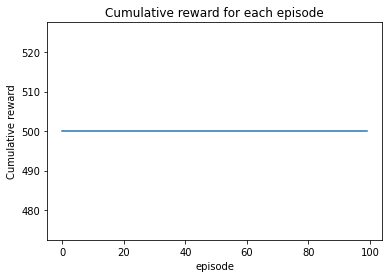

In [18]:


# Here we convert list to numpy for plotting convenience.
episode_results = np.array(episode_results)
print(episode_results)
plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

# Code reference: Self implemented

Print the average reward over the 100 episodes.

In [19]:

# Here we check if our agent passed assignment's requirement and if it is good enough.
print("Average cumulative reward:", episode_results.mean())
print("Is my agent good enough?", episode_results.mean() > 195)

# Code reference: Self implemented

Average cumulative reward: 500.0
Is my agent good enough? True


## Task 3: Render one episode played by the agent

Here, our agent is plugged in to demonstrate the rendered result.

If you cannot see our video rendered here, look at the submission folder for a video called 'one_episode_played_by_agent.mp4'.  
You can also head over to our google colab workspace to see the video rendered there.  
Feel free to duplicate it if you wish to run on google colab.  
Google Colab: https://drive.google.com/file/d/1dgJvCFymMeUToSsbR4JSetgoZSnAClm1/view?usp=sharing

In [20]:

# Here we run one episode to see a video played by the agent
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
while True:
    env.render()
    #your agent goes here
    action = actor_critic_agent(observation) # function called to get model's output (action) based on input (observation)
    observation, reward, done, info = env.step(action) # next step
    if done: # if done flag returns True, it means episode has ended (either it has finished 500 steps and truncated or it was terminated)
      break;    
env.close()
show_video()


# Code reference: Self implemented

# Conclusion

In conclusion, we have managed to implement a reinforcement learning method to solve the problem. This is by done by creating an actor-critic neural network and training in the environment. We have also demonstrated the effectiveness of the RL agent and rendered an animation to demonstrate the movements of the algorithm. Our choice for the use of actor-critic is due to the advantages that it brings: The actor-critic method requires minimal computation for seleting actions and they are also able to learn an explicitly stochastic policy by learning the optimal probabilities of selecting various actions. 

Source: http://www.incompleteideas.net/book/ebook/node66.html#:~:text=The%20policy%20structure%20is%20known,being%20followed%20by%20the%20actor.